In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from flash_ansr import get_path

In [3]:
# ids = {
#     'v19.0-6M': 'tdtdaeda',
#     'v19.0-17M': 'snse55ty',
#     'v19.0-60M': 'xw866au3',
#     'v19.0-160M': 'aor50qit',
# }

ids = {
    'v19.1-8M': '3bx1qktb',
    'v19.1-26M': 'qvowsbux',
    'v19.1-60M': 'bulh6877',
    'v19.1-160M': '5l5gy8oo',
}

# ids = {
#     'v19.2-8M': 'j6muy6hl',
#     'v19.2-26M': 'nhtqj70q',
# }

In [4]:
runs = {}
histories = {}
for version, run_id in ids.items():
    api = wandb.Api()
    run = api.run(f'psaegert/neural-symbolic-regression/{run_id}')
    runs[version] = run
    histories[version] = [x for x in tqdm(run.scan_history(page_size=100000), total=run.summary['_step'], desc=version)]

wandb: Currently logged in as: psaegert to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
v19.1-8M: 393326it [00:14, 26965.86it/s]                            
v19.1-26M: 100%|█████████▉| 1999807/2000000 [01:24<00:00, 23540.86it/s]
v19.1-60M: 1343590it [00:57, 23404.86it/s]                             
v19.1-160M: 661354it [00:25, 25567.26it/s]                            


In [5]:
data = {}
for version, history in histories.items():
    keys = history[0].keys()
    print(f"Keys for {version}: {keys}")
    data[version] = {k: np.array([(x[k] if k in x else np.nan) for x in history]).astype(float) for k in tqdm(keys, desc=version)}

val_data = {}
for version, d in data.items():
    valid_val_mask = ~np.isnan(d['val_ce_loss'])  # Only includes validation steps where the loss is available
    val_data[version] = {k: v[valid_val_mask] for k, v in d.items()}

Keys for v19.1-8M: dict_keys(['_runtime', '_timestamp', 'val_ce_loss', 'lr', 'total_pflops', 'val_mean_reciprocal_rank', '_step', 'train_loss', 'train_mean_reciprocal_rank', 'val_correct_token_predictions_at_1', 'train_correct_token_predictions_at_1', 'train_ce_loss', 'total_gradient_norm'])


v19.1-8M: 100%|██████████| 13/13 [00:00<00:00, 19.28it/s]


Keys for v19.1-26M: dict_keys(['val_correct_token_predictions_at_1', 'total_gradient_norm', 'val_mean_reciprocal_rank', 'train_mean_reciprocal_rank', 'total_pflops', 'train_ce_loss', '_step', '_runtime', 'train_loss', 'train_correct_token_predictions_at_1', 'lr', '_timestamp', 'val_ce_loss'])


v19.1-26M: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Keys for v19.1-60M: dict_keys(['val_correct_token_predictions_at_1', 'train_correct_token_predictions_at_1', '_timestamp', 'lr', 'val_ce_loss', 'total_pflops', 'total_gradient_norm', 'val_mean_reciprocal_rank', '_step', '_runtime', 'train_loss', 'train_ce_loss', 'train_mean_reciprocal_rank'])


v19.1-60M: 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Keys for v19.1-160M: dict_keys(['_runtime', 'val_ce_loss', 'train_ce_loss', 'val_mean_reciprocal_rank', 'val_correct_token_predictions_at_1', '_step', 'train_loss', 'total_pflops', 'train_correct_token_predictions_at_1', 'lr', '_timestamp', 'total_gradient_norm', 'train_mean_reciprocal_rank'])


v19.1-160M: 100%|██████████| 13/13 [00:00<00:00, 14.12it/s]


In [6]:
for version, d in val_data.items():
    val_data[version]['log_total_pflops'] = np.log10(d['total_pflops'])
    val_data[version]['log_val_ce_loss'] = np.log10(d['val_ce_loss'])

In [7]:
def scaling_law(x, a, b):
    return a * x + b

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00025125992623881784
        x: [-1.091e-01  4.283e-01]
      nit: 15
      jac: [-3.944e-08 -4.885e-08]
 hess_inv: [[ 7.802e-01 -3.094e+00]
            [-3.094e+00  1.235e+01]]
     nfev: 78
     njev: 26


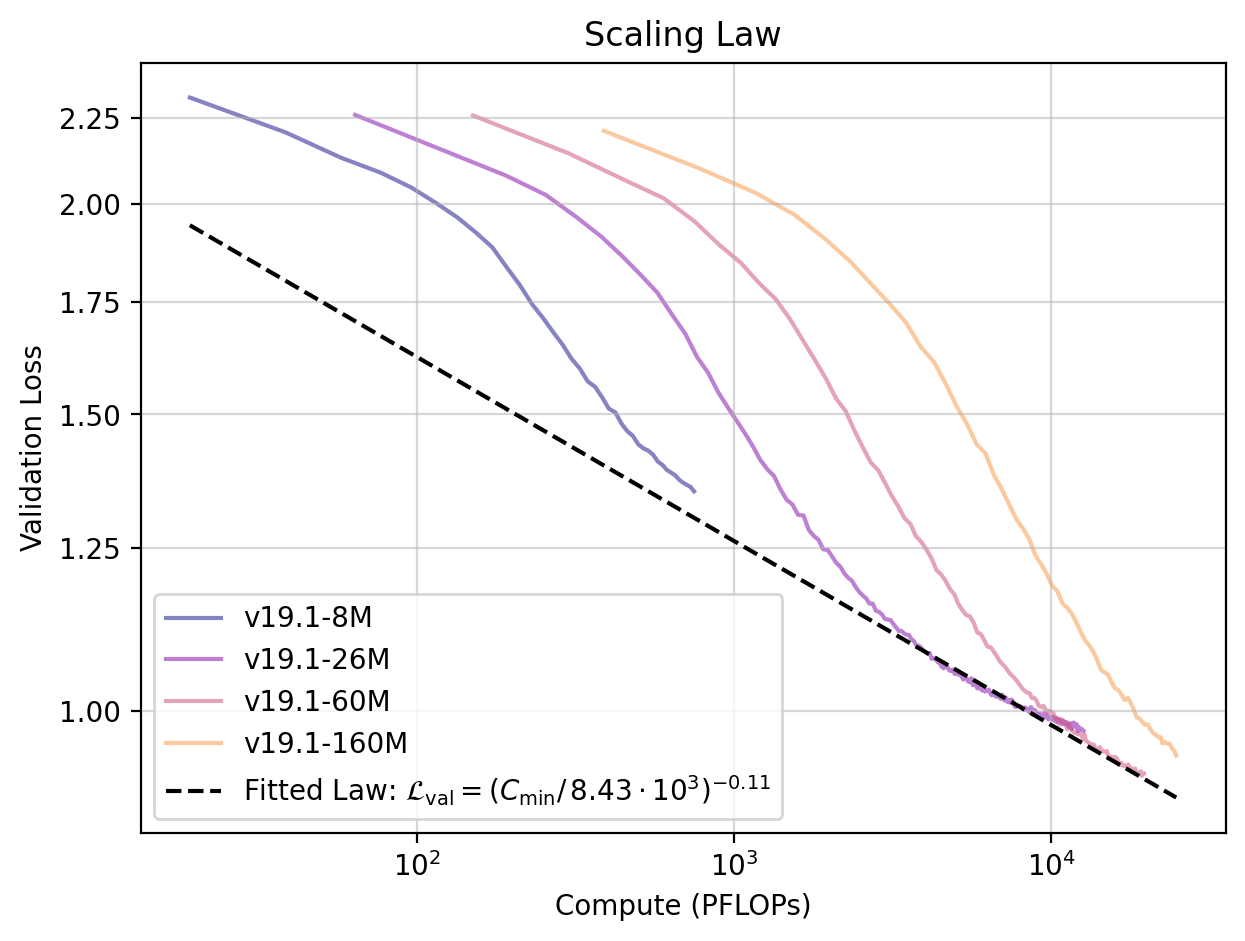

In [16]:
x_list = [d['log_total_pflops'] for d in val_data.values()]
y_list = [d['log_val_ce_loss'] for d in val_data.values()]

x_valid_list: list[np.ndarray] = []
y_valid_list: list[np.ndarray] = []

for x, y in zip(x_list, y_list):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_valid_list.append(x[mask])
    y_valid_list.append(y[mask])


def objective(params, x_valid_list: list[np.ndarray], y_valid_list: list[np.ndarray], penalty_weight=1.0):
    y_pred = [scaling_law(x, *params) for x in x_valid_list]

    individual_overshoot_penalties = [np.max((y_p - y).clip(min=0)**2) for y_p, y in zip(y_pred, y_valid_list)]

    individual_min_least_squares = [np.min((y_p - y)**2) for y_p, y in zip(y_pred, y_valid_list)]

    return penalty_weight * np.mean(individual_overshoot_penalties) + np.mean(individual_min_least_squares)

result = minimize(objective, x0=[-0.15, 2], args=(x_valid_list, y_valid_list, 10))

print(result)

a_fit, b_fit = result.x

# Transform to the form y = (x / b')^a'
# From the derivation: a' = a and b' = 10**(-b/a)
a_prime = a_fit
b_prime = 10**(-b_fit / a_fit)

x_fit = np.linspace(min(min(x) for x in x_list), max(max(x) for x in x_list), 10)
y_fit = scaling_law(x_fit, a_fit, b_fit)


fig, ax = plt.subplots(figsize=(7, 5), dpi=200)


colors = [plt.get_cmap('plasma')(i / len(val_data)) for i in range(len(val_data))]

# --- BOLD MINIMUM ---
# def margin(j):
#     return 0.01 + 1/(j+1)

# y_approx_argmin = np.array([np.argmin([y[(x > x_current - margin(j)) & (x < x_current + margin(j))].min() if np.any((x > x_current - margin(j)) & (x < x_current + margin(j))) else np.inf for x, y in zip(x_valid_list, y_valid_list)]) for j, x_current in enumerate(x_fit)])

# x_min = np.concatenate([x_valid_list[which_curve][(x_valid_list[which_curve] > x_current - margin(j)) & (x_valid_list[which_curve] < x_current + margin(j))] if np.any((x_valid_list[which_curve] > x_current - margin(j)) & (x_valid_list[which_curve] < x_current + margin(j))) else np.inf for j, (x_current, which_curve) in enumerate(zip(x_fit, y_approx_argmin))])
# y_min = np.concatenate([y_valid_list[which_curve][(x_valid_list[which_curve] > x_current - margin(j)) & (x_valid_list[which_curve] < x_current + margin(j))] if np.any((x_valid_list[which_curve] > x_current - margin(j)) & (x_valid_list[which_curve] < x_current + margin(j))) else np.inf for j, (x_current, which_curve) in enumerate(zip(x_fit, y_approx_argmin))])
# y_argmin = np.concatenate([np.full_like(y_valid_list[which_curve][(x_valid_list[which_curve] > x_current - margin(j)) & (x_valid_list[which_curve] < x_current + margin(j))], which_curve) if np.any((x_valid_list[which_curve] > x_current - margin(j)) & (x_valid_list[which_curve] < x_current + margin(j))) else np.inf for j, (x_current, which_curve) in enumerate(zip(x_fit, y_approx_argmin))]).astype(int)

# x_min_argsort = np.argsort(x_min)
# x_min = x_min[x_min_argsort]
# y_min = y_min[x_min_argsort]
# y_argmin = y_argmin[x_min_argsort]

# print(y_min.shape, x_min.shape)


# valid_mask = np.array(y_min) < np.inf


# for i in range(len(x_min[valid_mask]) - 1):
#     ax.plot([x_min[valid_mask][i], x_min[valid_mask][i + 1]], [y_min[valid_mask][i], y_min[valid_mask][i + 1]], c=colors[y_argmin[valid_mask][i]], zorder=3)

# /--- BOLD MINIMUM ---

for i, (version, d) in enumerate(val_data.items()):
    ax.plot(d['log_total_pflops'], d['log_val_ce_loss'], label=version, color=colors[i], alpha=0.5, zorder=1)

# Complete the label string using the transformed parameters
s = f'{b_prime:.2e}'
mantissa, exponent = s.split('e')
b_prime_latex = f'{mantissa} \\cdot 10^{{{int(exponent)}}}'

label = f'Fitted Law: $\\mathcal{{L}}_\\text{{val}} = (C_\\text{{min}} / \\, {b_prime_latex})^{{{a_prime:.2f}}}$'

xticks = np.arange(1, 5, 1)
ax.set_xticks(xticks)
ax.set_xticklabels([f'$10^{{{i}}}$' for i in xticks])
ytickslabels = np.arange(1, 2.8, 0.25)
yticks = np.log10(ytickslabels)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{y:.2f}' for y in ytickslabels])

ax.grid(alpha=0.5)

ax.plot(x_fit, y_fit, color='k', label=label, linestyle='--', zorder=3)
ax.set_xlabel('Compute (PFLOPs)')
ax.set_ylabel('Validation Loss')
ax.set_title('Scaling Law')
ax.legend()
plt.show()
